In [1]:
import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


import warnings
warnings.filterwarnings('ignore')


In [4]:
# importing csv
df = pd.read_csv('extractedMimic.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Columns: 106 entries, icustay_id to crystalloid_bolus
dtypes: float64(57), int64(39), object(10)
memory usage: 3.7+ MB


In [6]:
df.head()

,icustay_id,hadm_id,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,...,glucose_min1,glucose_max1,glucose_mean,rrt,subject_id,hadm_id.1,icustay_id.1,urineoutput,colloid_bolus,crystalloid_bolus
0,205941,156324,28/5/2157 14:26:21,30/5/2157 14:18:24,metavision,28/5/2157 15:30:00,-0.044201,MRSA SCREEN,0,28/5/2157 00:00:00,...,40.0,202.0,87.250000,0,88883,156324,205941,0.0,NaN,250.0
1,252848,163315,29/7/2196 02:26:17,29/7/2196 12:02:39,metavision,29/7/2196 04:57:00,-0.104664,MRSA SCREEN,1,29/7/2196 00:00:00,...,182.0,231.0,206.500000,0,46154,163315,252848,0.0,NaN,250.0
2,237901,180937,14/2/2145 17:55:07,23/2/2145 12:43:43,metavision,14/2/2145 21:20:00,-0.142280,BLOOD CULTURE,0,15/2/2145 00:00:00,...,123.0,185.0,151.285714,1,42682,180937,237901,0.0,NaN,250.0
3,207491,143962,11/6/2159 12:47:02,14/6/2159 16:31:30,metavision,11/6/2159 12:11:00,0.025023,BLOOD CULTURE,0,11/6/2159 00:00:00,...,92.0,118.0,105.000000,0,45111,143962,207491,4.0,NaN,250.0
4,293063,118489,1/1/2135 17:28:33,2/1/2135 06:56:56,metavision,1/1/2135 15:55:00,0.064965,BLOOD CULTURE,0,1/1/2135 00:00:00,...,150.0,163.0,155.000000,0,56648,118489,293063,5.0,NaN,250.0


In [7]:
df.describe()

,icustay_id,hadm_id,suspected_infection_time_poe_days,positiveculture_poe,blood_culture_positive,age,is_male,race_white,race_black,race_hispanic,...,glucose_min1,glucose_max1,glucose_mean,rrt,subject_id,hadm_id.1,icustay_id.1,urineoutput,colloid_bolus,crystalloid_bolus
count,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,...,4529.000000,4529.000000,4529.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,509.000000,3365.000000
mean,250659.192367,149895.166265,0.083937,0.136214,0.381005,65.131600,0.566133,0.718579,0.086203,0.033121,...,111.229852,410.820932,177.224451,0.043650,68163.638737,149895.166265,250659.192367,1843.328800,382.434185,645.720951
std,28770.209912,28713.760695,0.290735,0.343053,0.485687,17.671337,0.495662,0.449742,0.280695,0.178973,...,36.762217,14856.780903,2122.835511,0.204337,18480.543170,28713.760695,28770.209912,1537.356631,134.930173,369.976339
min,200075.000000,100003.000000,-0.991076,0.000000,0.000000,16.783400,0.000000,0.000000,0.000000,0.000000,...,12.000000,57.000000,52.444444,0.000000,165.000000,100003.000000,200075.000000,0.000000,150.000000,250.000000
25%,225575.500000,125389.000000,-0.075961,0.000000,0.000000,53.764350,0.000000,0.000000,0.000000,0.000000,...,89.000000,130.000000,113.000000,0.000000,53111.500000,125389.000000,225575.500000,897.500000,250.000000,500.000000
50%,251008.000000,149643.000000,0.034861,0.000000,0.000000,66.588700,1.000000,1.000000,0.000000,0.000000,...,106.000000,166.000000,134.190476,0.000000,68368.000000,149643.000000,251008.000000,1560.000000,500.000000,500.000000
75%,275526.000000,175033.000000,0.157309,0.000000,1.000000,79.525350,1.000000,1.000000,0.000000,0.000000,...,127.000000,217.000000,165.000000,0.000000,83771.500000,175033.000000,275526.000000,2460.000000,500.000000,1000.000000
max,299998.000000,199962.000000,0.995139,1.000000,1.000000,91.400000,1.000000,1.000000,1.000000,1.000000,...,480.000000,999999.000000,142966.857100,1.000000,99982.000000,199962.000000,299998.000000,50515.000000,1000.000000,11000.000000


In [8]:
count = df[df['age'] < 18].shape[0]  # Using .shape to get the row count
print(count)


4


In [9]:
df.drop(df[df['age'] < 18].index, inplace=True)

df.describe()

,icustay_id,hadm_id,suspected_infection_time_poe_days,positiveculture_poe,blood_culture_positive,age,is_male,race_white,race_black,race_hispanic,...,glucose_min1,glucose_max1,glucose_mean,rrt,subject_id,hadm_id.1,icustay_id.1,urineoutput,colloid_bolus,crystalloid_bolus
count,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,...,4525.000000,4525.000000,4525.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,508.000000,3361.000000
mean,250637.474863,149922.364874,0.084101,0.136334,0.381339,65.173619,0.565971,0.718771,0.086279,0.032931,...,111.232044,411.037348,177.261026,0.043469,68174.064105,149922.364874,250637.474863,1842.618441,382.694882,645.671229
std,28759.579721,28710.589841,0.290748,0.343180,0.485769,17.622075,0.495683,0.449649,0.280806,0.178475,...,36.773707,14863.345644,2123.773411,0.203932,18470.812604,28710.589841,28759.579721,1535.550605,134.934798,370.024064
min,200075.000000,100003.000000,-0.991076,0.000000,0.000000,18.020900,0.000000,0.000000,0.000000,0.000000,...,12.000000,57.000000,52.444444,0.000000,165.000000,100003.000000,200075.000000,0.000000,150.000000,250.000000
25%,225575.500000,125404.500000,-0.075677,0.000000,0.000000,53.784850,0.000000,0.000000,0.000000,0.000000,...,89.000000,130.000000,112.888889,0.000000,53134.000000,125404.500000,225575.500000,897.500000,250.000000,500.000000
50%,250984.000000,149667.000000,0.034965,0.000000,0.000000,66.591500,1.000000,1.000000,0.000000,0.000000,...,106.000000,166.000000,134.000000,0.000000,68391.000000,149667.000000,250984.000000,1560.000000,500.000000,500.000000
75%,275436.000000,175042.500000,0.157309,0.000000,1.000000,79.540400,1.000000,1.000000,0.000000,0.000000,...,127.000000,217.000000,165.000000,0.000000,83771.500000,175042.500000,275436.000000,2460.000000,500.000000,1000.000000
max,299998.000000,199962.000000,0.995139,1.000000,1.000000,91.400000,1.000000,1.000000,1.000000,1.000000,...,480.000000,999999.000000,142966.857100,1.000000,99982.000000,199962.000000,299998.000000,50515.000000,1000.000000,11000.000000


In [10]:
# checking missing values
df.isnull().sum()


icustay_id              0
hadm_id                 0
intime                  0
outtime                 0
dbsource                0
                     ... 
hadm_id.1               0
icustay_id.1            0
urineoutput             0
colloid_bolus        4047
crystalloid_bolus    1194
Length: 106, dtype: int64

In [11]:
df.shape

(4555, 106)

In [12]:
X = df[['urineoutput', 'lactate_min','bun_mean','sysbp_min', 'metastatic_cancer', 'inr_max', 'age', 'sodium_max', 'aniongap_max', 'creatinine_min', 'spo2_mean']]

y = df['thirtyday_expire_flag']

In [13]:
X.head()

,urineoutput,lactate_min,bun_mean,sysbp_min,metastatic_cancer,inr_max,age,sodium_max,aniongap_max,creatinine_min,spo2_mean
0,0.0,7.0,62.0,78.0,0,2.4,80.5274,132,27.0,3.0,95.275862
1,0.0,3.8,27.0,36.0,0,1.4,91.4000,137,16.0,1.8,NaN
2,0.0,1.7,19.5,45.0,0,1.4,80.9409,141,23.0,2.3,98.100000
3,4.0,0.8,56.5,78.0,0,1.2,84.8807,141,19.0,4.3,97.600000
4,5.0,4.1,32.0,75.0,0,2.1,73.8195,136,24.0,2.2,96.250000


In [14]:
X.isnull().sum()

urineoutput            0
lactate_min            0
bun_mean               0
sysbp_min              8
metastatic_cancer      0
inr_max              270
age                    0
sodium_max             0
aniongap_max          14
creatinine_min         2
spo2_mean              1
dtype: int64

In [15]:
X.shape

(4555, 11)

In [16]:
X.fillna(X.median(), inplace=True)

In [17]:
X.isnull().sum()

urineoutput          0
lactate_min          0
bun_mean             0
sysbp_min            0
metastatic_cancer    0
inr_max              0
age                  0
sodium_max           0
aniongap_max         0
creatinine_min       0
spo2_mean            0
dtype: int64

In [18]:
X.shape

(4555, 11)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4555 entries, 0 to 4558
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   urineoutput        4555 non-null   float64
 1   lactate_min        4555 non-null   float64
 2   bun_mean           4555 non-null   float64
 3   sysbp_min          4555 non-null   float64
 4   metastatic_cancer  4555 non-null   int64  
 5   inr_max            4555 non-null   float64
 6   age                4555 non-null   float64
 7   sodium_max         4555 non-null   int64  
 8   aniongap_max       4555 non-null   float64
 9   creatinine_min     4555 non-null   float64
 10  spo2_mean          4555 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 427.0 KB


In [20]:
# Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (3644, 11)
Testing set shape: (911, 11)


# -------------------------------------------------

# Apply XGBoost

In [21]:
# Step 1: Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic', n_estimators=200)
xgb_model.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred = xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy based on predicted labels
auc = roc_auc_score(y_test, y_probs)  # AUC based on predicted probabilities
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix based on predicted labels
class_report = classification_report(y_test, y_pred)  # Classification report based on predicted labels

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Model Accuracy: 83.64435%
Model AUC: 79.59194%
Confusion Matrix:
[[689  40]
 [109  73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       729
           1       0.65      0.40      0.49       182

    accuracy                           0.84       911
   macro avg       0.75      0.67      0.70       911
weighted avg       0.82      0.84      0.82       911



# -----------------------------------------------------------------------

# Hyperparameter Turing

In [22]:
# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]  # Regularization parameter to control overfitting
}

# Step 2: Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')

# Step 3: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# Step 4: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_xgb_model = grid_search.best_estimator_

# Step 5: Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = best_xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy based on predicted labels
auc = roc_auc_score(y_test, y_probs)  # AUC based on predicted probabilities
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix based on predicted labels
class_report = classification_report(y_test, y_pred)  # Classification report based on predicted labels

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

# --------------------------------------------------------------------------------

# adding Regularization to the code

In [70]:
# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter to control overfitting
    'alpha': [0, 0.1, 0.2],  # L1 regularization term
    'lambda': [1, 1.5, 2]    # L2 regularization term
}

# Step 2: Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')

# Step 3: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# Step 4: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_xgb_model = grid_search.best_estimator_

# Step 5: Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = best_xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy based on predicted labels
auc = roc_auc_score(y_test, y_probs)  # AUC based on predicted probabilities
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix based on predicted labels
class_report = classification_report(y_test, y_pred)  # Classification report based on predicted labels

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'alpha': 0, 'gamma': 0.2, 'lambda': 2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Model Accuracy: 85.62020%
Model AUC: 83.77048%
Confusion Matrix:
[[710  19]
 [112  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92       729
           1       0.79      0.38      0.52       182

    accuracy                           0.86       911
   macro avg       0.83      0.68      0.72       911
weighted avg       0.85      0.86      0.84       911



# --------------------------------------------------------------------------------

# adding Threshold Tuning to the code

In [69]:
# Step 1: Define the parameter grid for hyperparameter tuning, including regularization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
    'alpha': [0, 0.1, 0.2],  # L1 regularization term
    'lambda': [1, 1.5, 2]    # L2 regularization term
}

# Step 2: Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')

# Step 3: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# Step 4: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_xgb_model = grid_search.best_estimator_

# Step 5: Make predictions on the test set
y_probs = best_xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 6: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 7: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 8: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Default Threshold (0.5):
Model Accuracy: 85.62020%
Model AUC: 83.83153%
Confusion Matrix:
[[714  15]
 [116  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.81      0.36      0.50       182

    accuracy                           0.86       911
   macro avg       0.84      0.67      0.71       911
weighted avg       0.85      0.86      0.83       911


Best Threshold: 0.25
Best Threshold Performance:
Model Accuracy: 81.66850%
Model AUC: 83.83153%
Confusion Matrix:
[[619 110]
 [ 57 125]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       729
           1       0.53      0.69      0.60       182

    accuracy                           0.82       911
   macro avg       0.72      0.77      0.74       911
weighted avg       0.84      0.82      

In [24]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01, 0.1],
    'subsample': [1.0],
    'gamma': [0, 0.1, 0.2],  # Regularization parameter for tree pruning
#     'alpha': [0, 0.1, 0.2],  # L1 regularization term
#     'lambda': [1, 1.5, 2]    # L2 regularization term
}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with a logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Default Threshold (0.5):
Model Accuracy: 85.94951%
Model AUC: 84.24984%
Confusion Matrix:
[[712  17]
 [111  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       729
           1       0.81      0.39      0.53       182

    accuracy                           0.86       911
   macro avg       0.84      0.68      0.72       911
weighted avg       0.85      0.86      0.84       911


Best Threshold: 0.22
Best Threshold Performance:
Model Accuracy: 80.90011%
Model AUC: 84.24984%
Confusion Matrix:
[[614 115]
 [ 59 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       729
           1       0.52      0.68      0.59       182

    accuracy                           0.81       911
   macro avg       0.71      0.76      0.73       911
weighted avg       0.83      0.81      0.82 

In [27]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  # Increased number of estimators
    'max_depth': [3, 5],  # Slightly deeper trees to allow more complex splits
    'learning_rate': [0.01, 0.05, 0.1],  # Added finer control for learning rate
    'subsample': [0.8, 0.9, 1.0],  # Allow models to use less than full data for diversity
    'gamma': [0, 0.1],  # Increased regularization options to prevent overfitting
#     'alpha': [0, 0.1, 0.3, 0.5],  # Uncomment if you want to explore L1 regularization
#     'lambda': [1, 1.5, 2, 2.5]    # Uncomment if you want to explore L2 regularization
}


# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with a logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Default Threshold (0.5):
Model Accuracy: 85.40066%
Model AUC: 84.11643%
Confusion Matrix:
[[707  22]
 [111  71]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       729
           1       0.76      0.39      0.52       182

    accuracy                           0.85       911
   macro avg       0.81      0.68      0.72       911
weighted avg       0.84      0.85      0.83       911


Best Threshold: 0.21
Best Threshold Performance:
Model Accuracy: 80.68057%
Model AUC: 84.11643%
Confusion Matrix:
[[611 118]
 [ 58 124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       729
           1       0.51      0.68      0.58       182

    accuracy                           0.81       911
   macro avg       0.71      0.76      0.73       911
weighted avg       0.83      0.81      0.8

In [54]:
# Step 1: Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Calculate scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Step 3: Define the model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    booster='gbtree',
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
)

# Step 4: Set up parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 6, 7],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# Step 5: Use Stratified K-Folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 6: Perform Grid Search with ROC AUC as the scoring metric
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Step 7: Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the positive class

# Step 8: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)  # Calculate AUC

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"AUC Score: {auc_score:.5f}")  # Print AUC
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 3888 candidates, totalling 19440 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# Step 1: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [1.0],
    'gamma': [0, 0.1, 0.3],  # Regularization parameter for tree pruning
#     'alpha': [0, 0.1, 0.2],  # L1 regularization term
#     'lambda': [1, 1.5, 2]    # L2 regularization term
}

# Step 2: Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', booster='gbtree', objective='binary:logistic')),
    ('lr', LogisticRegression(max_iter=1000))
]

# Step 3: Define the stacking classifier with a logistic regression as the final estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Step 4: Set up the GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid={'xgb__' + k: v for k, v in param_grid.items()}, scoring='roc_auc', cv=5, verbose=1)

# Step 5: Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_stacking_model = grid_search.best_estimator_

# Step 6: Make predictions on the test set
y_probs = best_stacking_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Step 7: Evaluate the model's performance with the default threshold of 0.5
y_pred_default = (y_probs >= 0.5).astype(int)
accuracy_default = accuracy_score(y_test, y_pred_default)
auc_default = roc_auc_score(y_test, y_probs)
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
class_report_default = classification_report(y_test, y_pred_default)

# Print evaluation metrics for the default threshold
print("Default Threshold (0.5):")
print(f"Model Accuracy: {accuracy_default * 100:.5f}%")
print(f"Model AUC: {auc_default * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_default)
print("Classification Report:")
print(class_report_default)

# Step 8: Threshold tuning
# Determine the best threshold
thresholds = np.arange(0.0, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Step 9: Evaluate the model's performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)
accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_probs)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation metrics for the best threshold
print(f"\nBest Threshold: {best_threshold:.2f}")
print("Best Threshold Performance:")
print(f"Model Accuracy: {accuracy_best * 100:.5f}%")
print(f"Model AUC: {auc_best * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix_best)
print("Classification Report:")
print(class_report_best)

In [ ]:
# Step 1: Define the XGBoost classifier with initial hyperparameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, booster='gbtree', objective='binary:logistic')

# Step 2: Define hyperparameters for tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Controls the step size (lower = more conservative)
    'max_depth': [3, 5, 7, 9],             # Depth of each tree (higher = more complex model)
    'n_estimators': [100, 300, 500, 1000],     # Number of boosting rounds (trees)
    'subsample': [0.6, 0.8, 1.0],       # Ratio of samples used for training each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0] # Ratio of features used by each tree
}

# Step 3: Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 4: Best model from Grid Search
best_model = grid_search.best_estimator_

# Step 5: Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 7: Cross-validation on the entire training set
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")


Fitting 5 folds for each of 960 candidates, totalling 4800 fits


In [ ]:
# Step 1: Define the XGBoost classifier with initial hyperparameters
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, booster='gbtree', objective='multi:softprob')

# Step 2: Define hyperparameters for tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Controls the step size (lower = more conservative)
    'max_depth': [3, 5, 7, 9],             # Depth of each tree (higher = more complex model)
    'n_estimators': [100, 300, 500, 1000],     # Number of boosting rounds (trees)
    'subsample': [0.6, 0.8, 1.0],       # Ratio of samples used for training each tree
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0] # Ratio of features used by each tree
}

# Step 3: Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 4: Best model from Grid Search
best_model = grid_search.best_estimator_

# Step 5: Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Step 6: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 7: Cross-validation on the entire training set
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}%")


In [31]:
# Define features and target variable
X = df[['urineoutput', 'lactate_min', 'bun_mean', 'sysbp_min', 
         'metastatic_cancer', 'inr_max', 'age', 'sodium_max', 
         'aniongap_max', 'creatinine_min', 'spo2_mean']]
y = df['thirtyday_expire_flag']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance on the test set
auc_score = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["No Expiration", "Expiration"], output_dict=True)

# Calculate 95% Confidence Interval using Bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
rng = np.random.RandomState(42)

for _ in range(n_bootstraps):
    indices = rng.randint(0, len(y_pred_proba), len(y_pred_proba))
    if len(np.unique(y_test.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
    bootstrapped_scores.append(score)

# Confidence intervals
lower_bound = np.percentile(bootstrapped_scores, 2.5)
upper_bound = np.percentile(bootstrapped_scores, 97.5)

# Print the results
def print_classification_report(report):
    print("=== Model Performance Summary ===")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Model AUC: {auc_score:.2f}")
    print(f"95% Confidence Interval for AUC: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\n=== Detailed Classification Report ===\n")

    for label, metrics in report.items():
        if label in ["No Expiration", "Expiration"]:
            print(f"Class: {label}")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1-Score: {metrics['f1-score']:.2f}")
            print(f"  Support: {metrics['support']}")
            print()

    print(f"Overall Accuracy: {report['accuracy']:.2f}")
    print(f"Macro Average Precision: {report['macro avg']['precision']:.2f}")
    print(f"Macro Average Recall: {report['macro avg']['recall']:.2f}")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted Average Precision: {report['weighted avg']['precision']:.2f}")
    print(f"Weighted Average Recall: {report['weighted avg']['recall']:.2f}")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.2f}")

    print("\n=== Interpretation ===")
    print("The model shows good precision in predicting non-expiration cases, "
          "but recall for expiration cases indicates room for improvement.")
    print("Consider exploring class weighting or additional feature engineering to improve predictions for the minority class.")

print_classification_report(class_report)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
=== Model Performance Summary ===
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Model AUC: 0.83
95% Confidence Interval for AUC: [0.79, 0.86]

Confusion Matrix:
[[710  30]
 [106  66]]

=== Detailed Classification Report ===

Class: No Expiration
  Precision: 0.87
  Recall: 0.96
  F1-Score: 0.91
  Support: 740.0

Class: Expiration
  Precision: 0.69
  Recall: 0.38
  F1-Score: 0.49
  Support: 172.0

Overall Accuracy: 0.85
Macro Average Precision: 0.78
Macro Average Recall: 0.67
Macro Average F1-Score: 0.70
Weighted Average Precision: 0.84
Weighted Average Recall: 0.85
Weighted Average F1-Score: 0.83

=== Interpretation ===
The model shows good precision in predicting non-expiration cases, but recall for expiration cases indicates room for improvement.
Consider exploring class weighting or additional feature engineering to improve predictions for th

In [113]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Expanded hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
auc_score = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["No Expiration", "Expiration"], output_dict=True)

# Calculate 95% Confidence Interval using Bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
rng = np.random.RandomState(42)

for _ in range(n_bootstraps):
    indices = rng.randint(0, len(y_pred_proba), len(y_pred_proba))
    if len(np.unique(y_test.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
    bootstrapped_scores.append(score)

# Confidence intervals
lower_bound = np.percentile(bootstrapped_scores, 2.5)
upper_bound = np.percentile(bootstrapped_scores, 97.5)

# Print the results
def print_classification_report(report):
    print("=== Model Performance Summary ===")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Model AUC: {auc_score:.3f}")
    print(f"95% Confidence Interval for AUC: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\n=== Detailed Classification Report ===\n")

    for label, metrics in report.items():
        if label in ["No Expiration", "Expiration"]:
            print(f"Class: {label}")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1-Score: {metrics['f1-score']:.2f}")
            print(f"  Support: {metrics['support']}")
            print()

    print(f"Overall Accuracy: {report['accuracy']:.3f}")
    print(f"Macro Average Precision: {report['macro avg']['precision']:.2f}")
    print(f"Macro Average Recall: {report['macro avg']['recall']:.2f}")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted Average Precision: {report['weighted avg']['precision']:.2f}")
    print(f"Weighted Average Recall: {report['weighted avg']['recall']:.2f}")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.2f}")

    print("\n=== Interpretation ===")
    print("The model shows good precision in predicting non-expiration cases, "
          "but recall for expiration cases indicates room for improvement.")
    print("Consider exploring class weighting or additional feature engineering to improve predictions for the minority class.")

print_classification_report(class_report)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
=== Model Performance Summary ===
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Model AUC: 0.835
95% Confidence Interval for AUC: [0.80, 0.87]

Confusion Matrix:
[[711  29]
 [109  63]]

=== Detailed Classification Report ===

Class: No Expiration
  Precision: 0.87
  Recall: 0.96
  F1-Score: 0.91
  Support: 740.0

Class: Expiration
  Precision: 0.68
  Recall: 0.37
  F1-Score: 0.48
  Support: 172.0

Overall Accuracy: 0.849
Macro Average Precision: 0.78
Macro Average Recall: 0.66
Macro Average F1-Score: 0.69
Weighted Average Precision: 0.83
Weighted Average Recall: 0.85
Weighted Average F1-Score: 0.83

=== Interpretation ===
The model shows good precision in predicting non-expiration cases, but recall for expiration cases indicates room for improvement.
Consider exploring class weighting or additional feature engineering to improve predictions for 

Fitting 5 folds for each of 12288 candidates, totalling 61440 fits
=== Model Performance Summary ===
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Model AUC: 0.84
95% Confidence Interval for AUC: [0.80, 0.87]

Confusion Matrix:
[[712  28]
 [104  68]]

=== Detailed Classification Report ===

Class: No Expiration
  Precision: 0.87
  Recall: 0.96
  F1-Score: 0.92
  Support: 740.0

Class: Expiration
  Precision: 0.71
  Recall: 0.40
  F1-Score: 0.51
  Support: 172.0

Overall Accuracy: 0.86
Macro Average Precision: 0.79
Macro Average Recall: 0.68
Macro Average F1-Score: 0.71
Weighted Average Precision: 0.84
Weighted Average Recall: 0.86
Weighted Average F1-Score: 0.84

=== Interpretation ===
The model shows good precision in predicting non-expiration cases, but recall for expiration cases indicates room for improvement.
Consider exploring class weighting or additional feature 

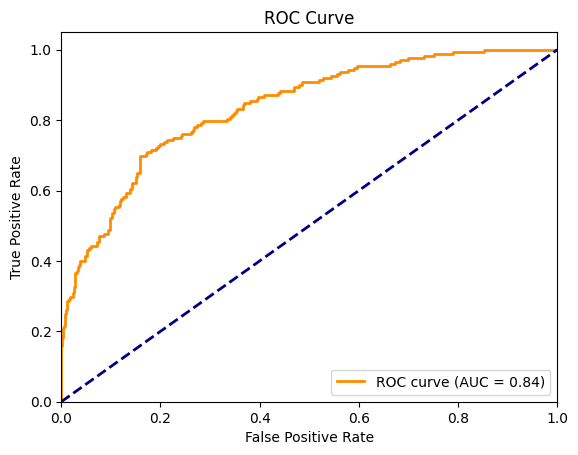

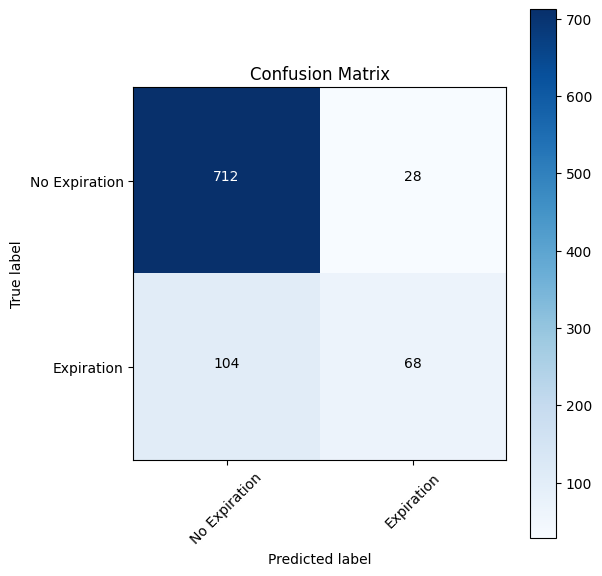

In [25]:
# Define features and target variable
X = df[['urineoutput', 'lactate_min', 'bun_mean', 'sysbp_min', 
         'metastatic_cancer', 'inr_max', 'age', 'sodium_max', 
         'aniongap_max', 'creatinine_min', 'spo2_mean']]
y = df['thirtyday_expire_flag']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Expanded hyperparameter grid for tuning
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300],
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'gamma': np.linspace(0, 1, 10),
    'alpha': [0, 0.01, 0.1, 1, 10],
    'lambda': [0, 0.01, 0.1, 1, 10],
    'scale_pos_weight': [1, 2, 5, 10],
}


# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
auc_score = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["No Expiration", "Expiration"], output_dict=True)

# Calculate 95% Confidence Interval using Bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
rng = np.random.RandomState(42)

for _ in range(n_bootstraps):
    indices = rng.randint(0, len(y_pred_proba), len(y_pred_proba))
    if len(np.unique(y_test.iloc[indices])) < 2:
        continue
    score = roc_auc_score(y_test.iloc[indices], y_pred_proba[indices])
    bootstrapped_scores.append(score)

# Confidence intervals
lower_bound = np.percentile(bootstrapped_scores, 2.5)
upper_bound = np.percentile(bootstrapped_scores, 97.5)

# Print the results
def print_classification_report(report):
    print("=== Model Performance Summary ===")
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    print(f"Model AUC: {auc_score:.2f}")
    print(f"95% Confidence Interval for AUC: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\n=== Detailed Classification Report ===\n")

    for label, metrics in report.items():
        if label in ["No Expiration", "Expiration"]:
            print(f"Class: {label}")
            print(f"  Precision: {metrics['precision']:.2f}")
            print(f"  Recall: {metrics['recall']:.2f}")
            print(f"  F1-Score: {metrics['f1-score']:.2f}")
            print(f"  Support: {metrics['support']}")
            print()

    print(f"Overall Accuracy: {report['accuracy']:.2f}")
    print(f"Macro Average Precision: {report['macro avg']['precision']:.2f}")
    print(f"Macro Average Recall: {report['macro avg']['recall']:.2f}")
    print(f"Macro Average F1-Score: {report['macro avg']['f1-score']:.2f}")
    print(f"Weighted Average Precision: {report['weighted avg']['precision']:.2f}")
    print(f"Weighted Average Recall: {report['weighted avg']['recall']:.2f}")
    print(f"Weighted Average F1-Score: {report['weighted avg']['f1-score']:.2f}")

    print("\n=== Interpretation ===")
    print("The model shows good precision in predicting non-expiration cases, "
          "but recall for expiration cases indicates room for improvement.")
    print("Consider exploring class weighting or additional feature engineering to improve predictions for the minority class.")

print_classification_report(class_report)
